# Section 2.1.2 Local Forward Sensitivity Analysis

In [1]:
using DiffEqSensitivity, OrdinaryDiffEq, ForwardDiff, Zygote, Plots, LaTeXStrings, Colors

#### Ebola spread model

In [3]:
function Ebola!(du,u,p,t)
    β,θ,ϕ,α,γ,γₕ,δ,δₕ,η,κ,b = p
    S,E,I,R,H,D,C,B = u
    N = S+E+I+R
    λ = β*(I/N)+θ*(H/N)+ϕ*(D/N) # force of infection
    du[1] = S′ = -λ*S
    du[2] = E′ = λ*S-α*E
    du[3] = I′ = α*E-(γ+η)*I+κ*H
    du[4] = R′ = (1-δ)*γ*I+(1-δₕ)*γₕ*H
    du[5] = H′ = η*I-(γₕ+κ)*H
    du[6] = D′ = δ*γ*I+δₕ*γₕ*H-b*D
    du[7] = C′ = α*E
    du[8] = B′ = b*D
end;

#### Parameters and initial conditions

In [25]:
# Parameters of the Ebola spread model
β = 0.532           # [1/week] Transmission rate in the community beforContinuousCallbacktervention
θ = 0.328           # [1/week] Transmission rate in hospitals before intervention
ϕ = 2.104           # [1/week] Transmission rate at funerals before intervention
α = 1.0/(10.0/7.0)  # [1/week] 1/(Mean duration of the incubation period)
γ =  1.0/(10.4/7.0) # [1/week] 1/(Mean duration of the infection)
γₕ = 1.0/(4.6/7.0)  # [1/week] 1/(Average permanence in the hospital)
δ = 0.73            # []       Case fatality rate in the community
δₕ = 0.61           # []       Case fatality ratio in hospitals
η = 1.0/(4.8/7.0)   # [1/week] 1/(Mean time from symptoms onset to hospitalization) before intervention
κ = 0.0025          # [1/week] Hospital leaving rate
b = 1.0/(5.4/7.0)   # [1/week] 1/(Mean time from death to burial) before intervention

# Initial values for the system
S₀ = 2.2e7 # Susceptible
E₀ = 3.42  # Exposed
I₀ = 2.31 # Infectious
R₀ = 0.0 # Removed
H₀ = 0.1 # Hospitalized
D₀ = 4.25 # Dead
C₀ = 0.0 # Cumulative number of infected cases
B₀ = 0.0 # Cumulative number of burials

q = [β,θ,ϕ,α,γ,γₕ,δ,δₕ,η,κ,b]
u₀ = [S₀,E₀,I₀,R₀,H₀,D₀,C₀,B₀];

#### ODE Problem

In [139]:
tspan = (0.0,25.0)
prob = ODEProblem(Ebola!,u₀,tspan,q);

In [185]:
prob = ODELocalSensitivityProblem(Ebola!,u₀,tspan,q; sensealg=ForwardSensitivity());
sol = solve(prob,DP8());
x,dq = extract_local_sensitivities(sol);

## Figure 2.5

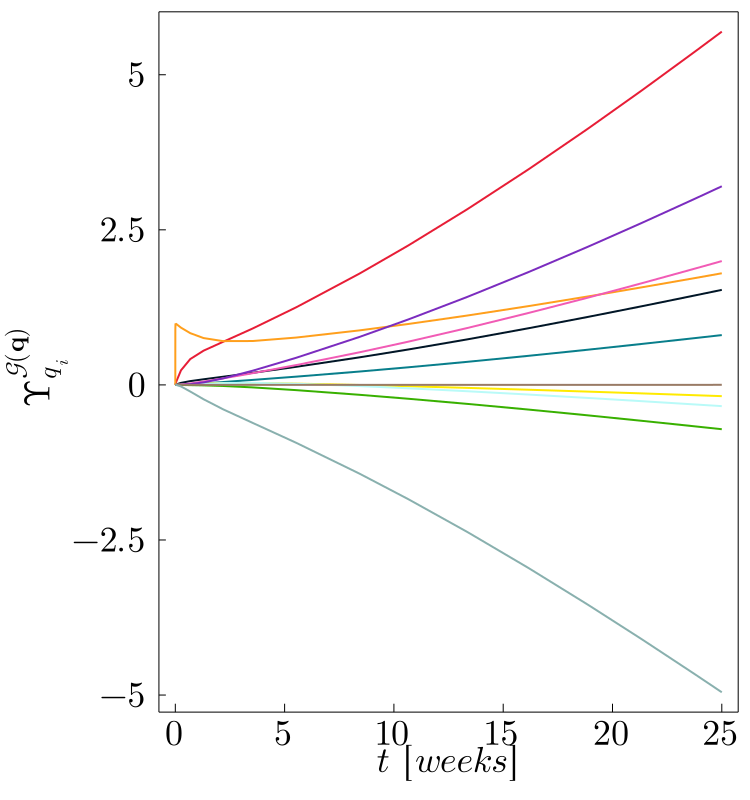

In [188]:
fontsize_tick=24
fontsize_legend=24
fonsize_label = 24
fonsize_titel = 24
# colors for plots
colors = [colorant"#011627",colorant"#087e8b",colorant"#e71d36",colorant"#ff9f1c",colorant"#ffea00",
          colorant"#b9faf8",colorant"#f15bb5",colorant"#7b2cbf",colorant"#38b000",colorant"#997b66",colorant"#89b0ae"]
labels = ["\\beta","_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_\\theta}",
          "_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_\\varphi}","_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_\\alpha}",
          "_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_\\gamma}","_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_{\\gamma_H}}",
          "_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_\\delta}","_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_{\\delta_H}}",
          "_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_\\eta}","_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_\\kappa}",
          "_{\\Upsilon^{\\mathcal{G}(\\mathbf{q})}_b}"]
labels = ["\\beta","\\theta","\\varphi","\\alpha","\\gamma","\\gamma_H","\\delta","\\delta_H",
          "\\eta", "\\kappa", "b"]
p1 = plot(legend=:none,lw=2,framestyle=:box, grid=:none,legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xlabel=L"t\;\;[weeks]",ylabel=L"\Upsilon^{\mathcal{G}(\mathbf{q})}_{q_i}",size=(750,800),
          xticks = ([0,5,10,15,20,25],[L"0", L"5",L"10", L"15", L"20", L"25"]),
          yticks = ([-5,-2.5,0,2.5,5],[L"-5",L"-2.5", L"0", L"2.5", L"5"])
)
ϵ = sqrt(eps(Float32))
for i in 1:11
    nfsi = dq[i][7,:].*(q[i]./(x[7,:].+ϵ))
    p1 = plot!(sol.t, nfsi, lw=2, label=L"%$(labels[i])", lc=colors[i])
end
plot(p1)

## Figure 2.4

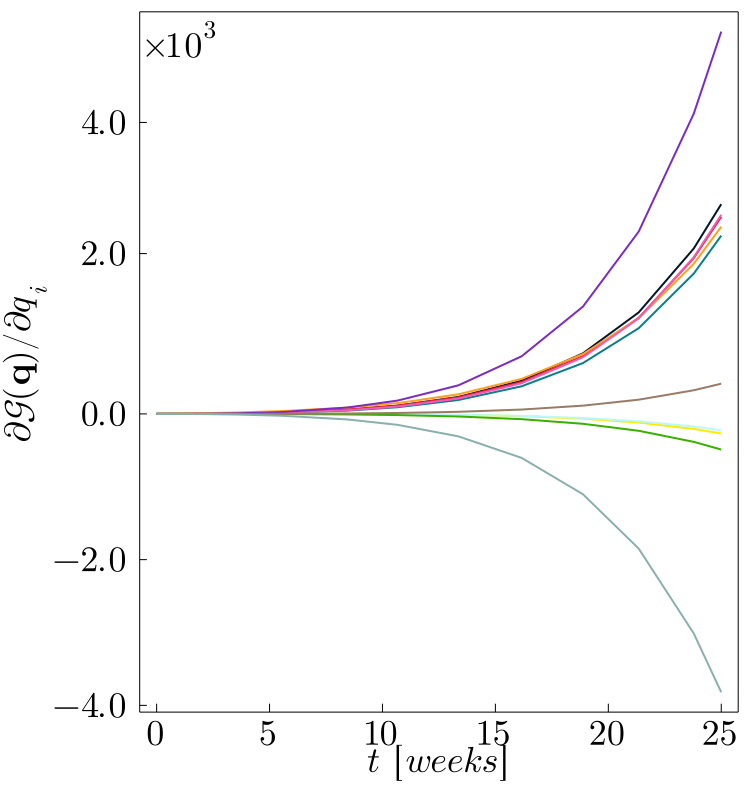

In [208]:
labels = ["\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\beta","\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\theta","\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\varphi",
          "\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\alpha","\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\gamma","\\partial \\mathcal{G}(\\mathbf{q})/\\partial {\\gamma_H}",
          "\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\delta","\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\delta_H","\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\eta",
          "\\partial \\mathcal{G}(\\mathbf{q})/\\partial \\kappa","\\partial \\mathcal{G}(\\mathbf{q})/\\partial b"]
labels = ["\\beta","\\theta","\\varphi","\\alpha","\\gamma","\\gamma_H","\\delta","\\delta_H",
          "\\eta", "\\kappa", "b"]
p1 = plot(legend=:none,lw=2,framestyle=:box, grid=:none,legendfontsize=fontsize_legend,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
          xlabel=L"t\;\;[weeks]",size=(750,800),
          xticks = ([0,5,10,15,20,25],[L"0", L"5",L"10", L"15", L"20", L"25"]),
          yaxis=(formatter=y->string(round(y / 10^3,digits=1))),
    ylabel=L"\partial \mathcal{G}(\mathbf{q})/\partial q_i",
          yticks = ([-4.0e3,-2e3,0.0,2.2e3,4.0e3],[L"-4.0", L"-2.0", L"0.0",L"2.0",L"4.0"])
)
     
ϵ = sqrt(eps(Float32))
for i in 1:11
    lfsi = dq[i][7,:]
    p1 = plot!(sol.t, lfsi, lw=2, label=L"%$(labels[i])",lc=colors[i])
end
p1 = annotate!([(1.2, 4.825e3 * 1.065, Plots.text(L"\times10^{3}", 24, :black, :center))])
plot(p1)

## Figure 2.6

β: 1.53
θ: 0.8
ϕ: 5.7
α: 1.8
γ: -0.18
γₕ: -0.34
δ: 2.0
δₕ: 3.2
η: -0.71
κ: 0.0
b: -4.96


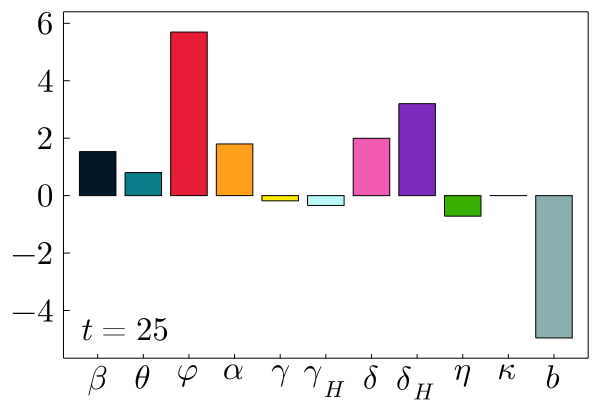

In [183]:
prob = ODELocalSensitivityProblem(Ebola!,u₀,tspan,q; sensealg=ForwardSensitivity());
sol = solve(prob,DP8(), saveat=1);
x,dq = extract_local_sensitivities(sol);

time = 26
fontsize_tick=22
p1 = bar(legend=:none,framestyle=:box, grid=:none,legendfontsize=fontsize_legend,
         yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,
         yticks = ([-4,-2,0,2,4,6],[L"-4",L"-2", L"0", L"2",L"4",L"6"]), ylim=(-5.66,6.4),
         xticks = (collect(1:11),[L"\beta",L"\theta",L"\varphi",L"\alpha",L"\gamma",L"\gamma_H",L"\delta",L"\delta_H",
          L"\eta", L"\kappa", L"b"]),)
labels = ["β","θ","ϕ","α","γ","γₕ","δ","δₕ","η","κ","b"]
ϵ = sqrt(eps(Float32))
for i in 1:11
    nfsi = dq[i][7,time]*(q[i]/(x[7,time]+ϵ))
    p1 = bar!([i],[nfsi],fillcolor=colors[i])
    println("$(labels[i]): ",round(nfsi,digits=2))
end
p1 = annotate!([(1.625, -4.66, Plots.text(L"t = 25", 22, :black, :center))])
plot(p1)

## Figure 2.7

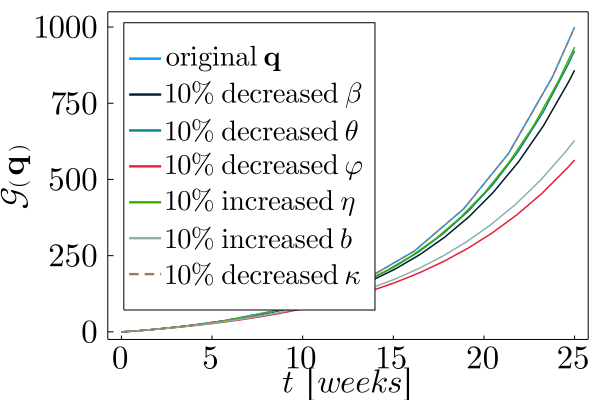

In [230]:
labels = ["\\textrm{original} \\; \\textbf{q}","10\\% \\; \\textrm{decreased} \\; \\beta","10\\% \\; \\textrm{decreased} \\; \\theta",
          "10\\% \\; \\textrm{decreased} \\; \\varphi","10\\% \\; \\textrm{increased} \\; \\eta","10\\% \\; \\textrm{increased} \\; b"]

fontsize_tick=22
fontsize_legend=19
fonsize_label = 22

q = [β,θ,ϕ,α,γ,γₕ,δ,δₕ,η,κ,b]
prob = ODELocalSensitivityProblem(Ebola!,u₀,tspan,q; sensealg=ForwardSensitivity());
sol = solve(prob,DP8());
x,dq = extract_local_sensitivities(sol);
# change parameters with high sensitivity
p1 = plot(sol.t, getindex.(sol.u,7); legend=:topleft,lw=1.5,legendfontsize=fontsize_legend,grid=:none,framestyle=:box,
          yguidefontsize=fonsize_label, xguidefontsize=fonsize_label,xtickfontsize=fontsize_tick,ytickfontsize=fontsize_tick,xlabel=L"t\;\;[weeks]",
          xticks = ([0,5,10,15,20,25],[L"0", L"5",L"10", L"15", L"20", L"25"]),ylim=(-25,1050),
#           yaxis=(formatter=y->string(round(y / 10^3,digits=1))), 
          yticks = ([0.0,250,500,750,1000],[L"0", L"250", L"500",L"750",L"1000"]),
          label=L"%$(labels[1])", ylabel=L"\mathcal{G}\left(\mathbf{q}\right)")

idx_q_to_change = [1,2,3,9,11]
for (idx, i) in enumerate(idx_q_to_change)
    remake_q = copy(q)
    if i <= 3
        remake_q[i] = q[i]-0.1*q[i]
    else
        remake_q[i] = q[i]+0.1*q[i]
    end
    remake_prob = remake(prob;p=remake_q) 
    remake_sol = solve(remake_prob,Tsit5());
    p1 = plot!(remake_sol.t, getindex.(remake_sol.u,7),lw=1.5, label=L"%$(labels[idx+1])",lc=colors[i])
end
    # plot the hospital leaving rate
    remake_q = copy(q)
    remake_q[10] = q[10]-0.1*q[10]
    remake_prob = ODELocalSensitivityProblem(Ebola!,u₀,tspan,remake_q; sensealg=ForwardSensitivity());
    remake_sol = solve(remake_prob,DP8());
    p1 = plot!(remake_sol.t, getindex.(remake_sol.u,7),lw=1.5, label=L"10\% \; \textrm{decreased} \; \kappa",lc=colors[10], ls=:dash)

# p1 = annotate!([(2.8, 8e3 * 1.02, Plots.text(L"\times10^{3}", 22, :black, :center))])
plot(p1)